# Introdução
Abaixo você irá encontrar o desenvolvimento do modelo de machine learning XGBoost. A estrutura do notebook esta dividida da seguinte maneira.

- Bibliotecas de importação
- Função de Importação dos dados.
    - Tratamento inicial dos dados com base na análise exploratória.
- Criação do Modelo de Previsão
    - Feature Engineering (Explicação na própria função)
    - Modelo
    - Métricas de Avaliação  
- Resultados

# Bibliotecas

In [1]:
# Standards Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mahcine learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.under_sampling import TomekLinks


# Importação dos Dados

In [2]:
class Data:
    def __init__(self):
        self.data = self.data_load()
       
    def data_load(self) -> pd.DataFrame:
        """
        This function will import the dataset.
        """
        data = pd.read_csv("./Dados/hotel_reservations.csv")
        return data
    
    def data_treatment(self,data) -> None:
        """
        This function will treat the dataset.
        All the informations about the data transformation were identifity in the exploratory_data_analysis.
        """
        dt = data.copy()
        ID = dt.pop('Booking_ID') # Removing ID
        
        # Transform categorical feature into numeric feature.
        cat = dt.select_dtypes(exclude=np.number).columns

        
        dt.loc[(dt['no_of_adults'] == 4) | (dt['no_of_adults'] == 0), 'no_of_adults'] = 3
        dt.loc[(dt['no_of_children'] > 2), 'no_of_children'] = 2
        dt.loc[(dt['no_of_weekend_nights'] > 2), 'no_of_weekend_nights'] = 2
        dt.loc[(dt['type_of_meal_plan'] == 'Meal Plan 3'), 'type_of_meal_plan'] = 'Meal Plan 2'
        dt.loc[(dt['room_type_reserved'] == 'Room_Type 5') | (dt['room_type_reserved'] == 'Room_Type 7') | (dt['room_type_reserved'] == 'Room_Type 3') , 'room_type_reserved'] = 'Room_Type 0'
        
        dt.loc[(dt['no_of_previous_cancellations'] > 0), 'no_of_previous_cancellations'] = 1
        dt.loc[(dt['no_of_special_requests'] > 0), 'no_of_special_requests'] = 1
        dt.loc[(dt['market_segment_type'] == 'Complementary') |
               (dt['market_segment_type'] == 'Aviation'), 'market_segment_type'] = 'Corporate'
        
        dt.loc[(dt['no_of_previous_bookings_not_canceled'] > 0), 'no_of_previous_bookings_not_canceled'] = 1

        for feature in cat:
            dt[feature] = LabelEncoder().fit_transform(dt[feature])
            
        
        return dt, ID
        

In [3]:
# Data Import
df = Data().data_load()
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
df,ID = Data().data_treatment(df)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,0,0,1,224,2017,10,2,1,0,0,0,65.00,0,1
1,2,0,2,3,2,0,1,5,2018,11,6,2,0,0,0,106.68,1,1
2,1,0,2,1,0,0,1,1,2018,2,28,2,0,0,0,60.00,0,0
3,2,0,0,2,0,0,1,211,2018,5,20,2,0,0,0,100.00,0,0
4,2,0,1,1,2,0,1,48,2018,4,11,2,0,0,0,94.50,0,0


# Modelo Previsor

In [6]:
class Modelo:
    def __init__(self, independents, target):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(independents, 
                                                                                target,
                                                                                test_size=0.2,
                                                                                random_state=42)
        self.dados_tratados = self.feature_engineering()
    def feature_engineering(self):
        """
        Etapas do tratamento: 
        - Binning dos dados numéricos que foram significativos no EDA.
        - Power Transformation para tratar os Outliers.
        - Criação de novas features misturando duas das mais influentes.
        - Balanceamento dos dados usando Tomek Link
        - Padronizando os dados.
        """   
        
        # Binning numeric features
            # Train
        self.X_train['cat_lead_time'] = pd.cut(self.X_train['lead_time'], bins = 10, duplicates='drop')
        self.X_train['cat_avg_price_per_room'] = pd.cut(self.X_train['avg_price_per_room'], bins = 10, duplicates='drop')

        cat_lead_time_bins = self.X_train['cat_lead_time'].unique().categories.left.to_list()
        cat_avg_price_per_room_bins = self.X_train['cat_avg_price_per_room'].unique().categories.left.to_list()
        
        
            # Test
        self.X_test['cat_lead_time'] = pd.cut(self.X_test['lead_time'], bins=cat_lead_time_bins, labels=False)
        self.X_test['cat_avg_price_per_room'] = pd.cut(self.X_test['avg_price_per_room'], bins=cat_avg_price_per_room_bins, labels=False)
        
        self.X_test['cat_lead_time'] = self.X_test['cat_lead_time'].fillna(self.X_test['cat_lead_time'].max())
        self.X_test['cat_avg_price_per_room'] = self.X_test['cat_avg_price_per_room'].fillna(self.X_test['cat_avg_price_per_room'].max())
        #     
        num = self.X_train.select_dtypes(include=np.number).columns
        cat = list(set(self.X_train.columns) - set(num))
        
        for feature in cat:
            self.X_train[feature] = LabelEncoder().fit_transform(self.X_train[feature])  
            
            
        # Power Transformation for numeric Features.
            # Train
        self.X_train['avg_price_per_room'] = np.log(self.X_train['avg_price_per_room']+1) 
            # Test
        self.X_test['avg_price_per_room'] = np.log(self.X_test['avg_price_per_room']+1) 
        
        # Feature Creation
        
        self.X_train['new_feature'] = self.X_train['avg_price_per_room'] * self.X_train['lead_time']
        self.X_test['new_feature'] = self.X_test['avg_price_per_room'] * self.X_test['lead_time']
        
        
        # Balancing Data
        
        tl = TomekLinks()
        self.X_train, self.y_train = tl.fit_resample(self.X_train, self.y_train)
        
        # Standard Scaler
        self.X_train.iloc[:,:] = StandardScaler().fit_transform(self.X_train.iloc[:,:])
        self.X_test.iloc[:,:] = StandardScaler().fit_transform(self.X_test.iloc[:,:])
                
        return {'X_train':self.X_train, 
                'X_test':self.X_test, 
                'y_train':self.y_train, 
                'y_test':self.y_test}
        
    def logistic(self, n_features):
        estimator = RandomForestClassifier(
            n_estimators=500,
            max_depth = 30
        )
        selector = RFE(estimator, n_features_to_select=n_features)
        X_train_rfe = selector.fit_transform(self.dados_tratados['X_train'], self.dados_tratados['y_train'])
        X_test_rfe = selector.transform(self.dados_tratados['X_test'])
        
        selected_feature_indices = selector.get_support(indices=True)
        selected_feature_names = [self.dados_tratados['X_train'].columns[i] for i in selected_feature_indices]
        print(f"\nFeatures Selecionadas = {selected_feature_names}\n")
        
        estimator.fit(X_train_rfe, self.dados_tratados['y_train'])
        y_pred = estimator.predict(X_test_rfe)
        y_proba = estimator.predict_proba(X_test_rfe)[:, 1]
        
        self.metricas(self.dados_tratados['y_test'], y_pred, y_proba)
        self.graphics(self.dados_tratados['y_test'], y_pred, y_proba)
    def metricas(self, y_true, y_score, y_proba):
        auc = roc_auc_score(y_true, y_proba)
        print(f"ROC AUC: {auc*100:.2f}\n")
        gini = 2 * auc - 1
        print(f"Índice de Gini: {gini*100:.2f}\n")
        
        fpr, tpr, thresholds = roc_curve(y_true, y_proba)
        ks = max(tpr - fpr)
        print(f"KS: {ks*100:.2f}\n")

        print(classification_report(y_true, y_score))
        
    def graphics(self, y_true, y_score, y_proba):
        # Calcula a curva ROC
        fpr, tpr, thresholds = roc_curve(y_true, y_proba)

        # Calcula a matriz de confusão
        cm = confusion_matrix(y_true, y_score)

        # Plot da curva ROC
        plt.figure(figsize=(10,4))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='green', label='ROC curve')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()

        # Plot da matriz de confusão
        cm_labels = ['Cancelado', 'Não cancelado']
        plt.subplot(1, 2, 2)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',xticklabels=cm_labels, yticklabels=cm_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')

        plt.tight_layout()
        plt.show()

# Resultados


Features Selecionadas = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'type_of_meal_plan', 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type', 'avg_price_per_room', 'no_of_special_requests', 'cat_lead_time', 'cat_avg_price_per_room', 'new_feature']

ROC AUC: 94.67

Índice de Gini: 89.35

KS: 76.40

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2416
           1       0.91      0.94      0.92      4839

    accuracy                           0.89      7255
   macro avg       0.88      0.87      0.88      7255
weighted avg       0.89      0.89      0.89      7255



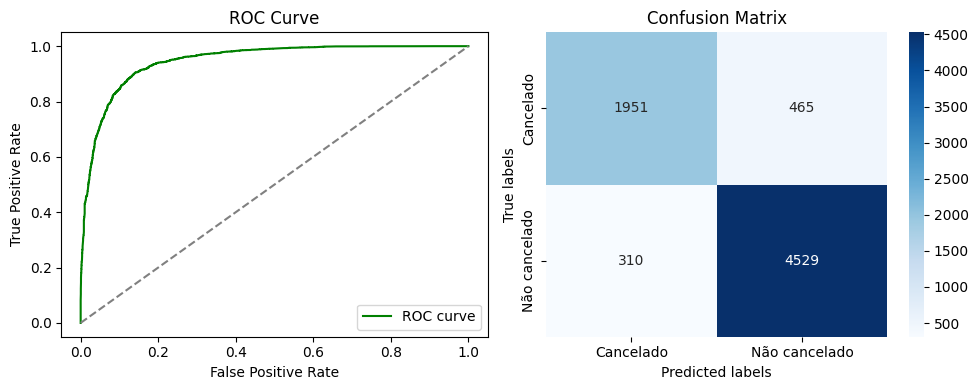

In [7]:
independents = df.copy()
target = independents.pop("booking_status")
Modelo(independents, target).logistic(16)